compute Energy, SLA, Scaling-actions

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/Users/azka/Downloads/Java"
EXPORTS_DIR = os.path.join(BASE_DIR, "exports")
PRED_PATH = os.path.join(BASE_DIR, "data", "bitbrains_predictions_for_cloudsim.csv")

# --- Load policy results ---
static_df = pd.read_csv(os.path.join(EXPORTS_DIR, "results_static.csv"))
pred_df   = pd.read_csv(os.path.join(EXPORTS_DIR, "results_predictive.csv"))
react_df  = pd.read_csv(os.path.join(EXPORTS_DIR, "results_reactive.csv"))

print("Static:", static_df.shape)
print("Predictive:", pred_df.shape)
print("Reactive:", react_df.shape)

static_df.head(), pred_df.head(), react_df.head()


Static: (4, 5)
Predictive: (4, 5)
Reactive: (5, 4)


(     time  slot  vm_id  pred_cpu  vm_count
 0    0.10     0      1      -1.0         2
 1   10.10    10      1      -1.0         2
 2  100.00   100      1      -1.0         2
 3  100.11   100      1      -1.0         2,
      time  slot  vm_id  pred_cpu  vm_count
 0    0.10     0      1   15.8108         2
 1   10.10    10      1    6.5011         1
 2  100.00   100      1    0.8901         1
 3  100.11   100      1    0.8901         1,
      time  slot  avg_cpu_percent  vm_count
 0    0.10     0         100.0000         2
 1   10.10    10          66.6667         3
 2   10.20    10          66.6667         3
 3  100.00   100          66.6667         3
 4  100.11   100           0.0000         3)

Attach predicted CPU to each policy

In [11]:
 # Load full prediction file (only VM 1 for now)
pred_all = pd.read_csv(PRED_PATH)

# Make sure column names match this:
# ['slot','vm_id','target_cpu_future','target_high_load','pred_cpu_future','pred_high_load']
print(pred_all.columns)

pred_vm1 = (
    pred_all[pred_all["vm_id"] == 1][["slot", "pred_cpu_future"]]
    .rename(columns={"pred_cpu_future": "pred_cpu"})
)

pred_vm1.head()


Index(['slot', 'vm_id', 'target_cpu_future', 'target_high_load',
       'pred_cpu_future', 'pred_high_load'],
      dtype='object')


,slot,pred_cpu
0,0,15.810750
1,1,14.845571
2,2,9.758000
3,3,9.291167
4,4,8.572417


Now merge into each policy dataframe:

In [12]:
def attach_pred_cpu(df, name):
    df = df.copy()
    # Reactive file has 'avg_cpu_percent' instead of 'pred_cpu', which is fine.
    if "pred_cpu" not in df.columns:
        df = df.merge(pred_vm1, on="slot", how="left")
    else:
        # For predictive, just ensure types are correct
        df["pred_cpu"] = df["pred_cpu"].astype(float)
    df["policy"] = name
    return df

static_df2 = attach_pred_cpu(static_df, "static")
pred_df2   = attach_pred_cpu(pred_df, "predictive")
react_df2  = attach_pred_cpu(react_df, "reactive")

static_df2.head(), pred_df2.head(), react_df2.head()


(     time  slot  vm_id  pred_cpu  vm_count  policy
 0    0.10     0      1      -1.0         2  static
 1   10.10    10      1      -1.0         2  static
 2  100.00   100      1      -1.0         2  static
 3  100.11   100      1      -1.0         2  static,
      time  slot  vm_id  pred_cpu  vm_count      policy
 0    0.10     0      1   15.8108         2  predictive
 1   10.10    10      1    6.5011         1  predictive
 2  100.00   100      1    0.8901         1  predictive
 3  100.11   100      1    0.8901         1  predictive,
      time  slot  avg_cpu_percent  vm_count   pred_cpu    policy
 0    0.10     0         100.0000         2  15.810750  reactive
 1   10.10    10          66.6667         3   6.501149  reactive
 2   10.20    10          66.6667         3   6.501149  reactive
 3  100.00   100          66.6667         3   0.890128  reactive
 4  100.11   100           0.0000         3   0.890128  reactive)

In [ ]:
#1.2 Helper to compute metrics for one policy

def compute_metrics(df, sla_threshold=60.0):
    """
    df must have columns: time, vm_count, pred_cpu
    Returns dict of metrics.
    """
    df = df.sort_values("time").reset_index(drop=True)
    
    times = df["time"].values
    vms   = df["vm_count"].values
    pred  = df["pred_cpu"].values

    # --- 1) Energy proxy: sum(vm_count * delta_time) ---
    dt = np.diff(times, prepend=times[0])   # first interval 0
    energy_vm_time = float(np.sum(vms * dt))

    # --- 2) SLA violation: predicted load per VM > threshold ---
    # If pred_cpu is NaN (e.g. no prediction), treat as no violation
    valid = ~np.isnan(pred)
    per_vm_load = np.zeros_like(pred, dtype=float)
    per_vm_load[valid] = pred[valid] / vms[valid].clip(min=1)

    violations = np.logical_and(valid, per_vm_load > sla_threshold).sum()
    total_samples = valid.sum()
    sla_violation_rate = violations / total_samples if total_samples > 0 else 0.0

    # --- 3) Scaling actions: how many times VM count changes ---
    scaling_actions = int((df["vm_count"].diff() != 0).sum())

    metrics = {
        "policy": df["policy"].iloc[0],
        "total_time": float(times[-1] - times[0]),
        "avg_vm_count": float(vms.mean()),
        "min_vm_count": int(vms.min()),
        "max_vm_count": int(vms.max()),
        "energy_vm_time": energy_vm_time,
        "sla_violation_rate": sla_violation_rate,
        "num_sla_violations": int(violations),
        "num_samples": int(total_samples),
        "scaling_actions": scaling_actions,
    }
    return metrics

metrics_static     = compute_metrics(static_df2)
metrics_predictive = compute_metrics(pred_df2)
metrics_reactive   = compute_metrics(react_df2)

metrics_static, metrics_predictive, metrics_reactive


({'policy': 'static',
  'total_time': 100.01,
  'avg_vm_count': 2.0,
  'min_vm_count': 2,
  'max_vm_count': 2,
  'energy_vm_time': 200.02,
  'sla_violation_rate': np.float64(0.0),
  'num_sla_violations': 0,
  'num_samples': 4,
  'scaling_actions': 1},
 {'policy': 'predictive',
  'total_time': 100.01,
  'avg_vm_count': 1.25,
  'min_vm_count': 1,
  'max_vm_count': 2,
  'energy_vm_time': 100.01,
  'sla_violation_rate': np.float64(0.0),
  'num_sla_violations': 0,
  'num_samples': 4,
  'scaling_actions': 2},
 {'policy': 'reactive',
  'total_time': 100.01,
  'avg_vm_count': 2.8,
  'min_vm_count': 2,
  'max_vm_count': 3,
  'energy_vm_time': 300.03,
  'sla_violation_rate': np.float64(0.0),
  'num_sla_violations': 0,
  'num_samples': 5,
  'scaling_actions': 2})

In [ ]:

summary_df = pd.DataFrame(
    [metrics_static, metrics_predictive, metrics_reactive]
).set_index("policy")

summary_df


,total_time,avg_vm_count,min_vm_count,max_vm_count,energy_vm_time,sla_violation_rate,num_sla_violations,num_samples,scaling_actions
policy,,,,,,,,,
static,100.01,2.00,2,2,200.02,0.0,0,4,1
predictive,100.01,1.25,1,2,100.01,0.0,0,4,2
reactive,100.01,2.80,2,3,300.03,0.0,0,5,2


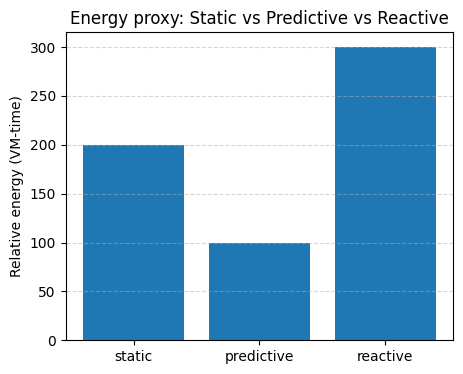

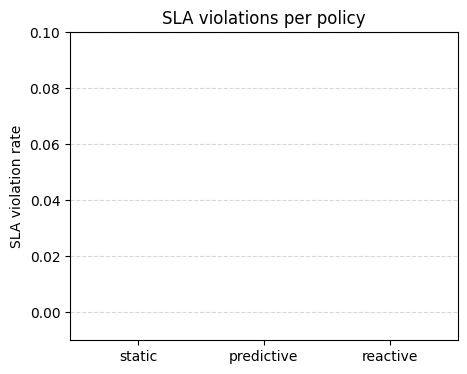

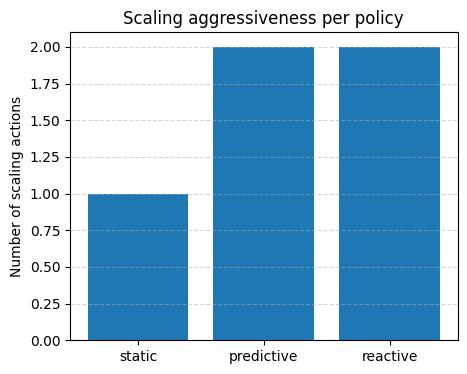

In [15]:
# Plot energy proxy comparison
plt.figure(figsize=(5,4))
plt.bar(summary_df.index, summary_df["energy_vm_time"])
plt.ylabel("Relative energy (VM-time)")
plt.title("Energy proxy: Static vs Predictive vs Reactive")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(5,4))
plt.bar(summary_df.index, summary_df["sla_violation_rate"])
plt.ylabel("SLA violation rate")
plt.title("SLA violations per policy")
plt.ylim(-0.01, 0.1)   # small range
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


#Scaling actions (how “nervous” the policy is)
plt.figure(figsize=(5,4))
plt.bar(summary_df.index, summary_df["scaling_actions"])
plt.ylabel("Number of scaling actions")
plt.title("Scaling aggressiveness per policy")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Static: highest energy (constant 2 VMs), 0 scaling actions, 
no SLA violations (over-provisioning).

Predictive (ML): lowest energy, very few scaling actions, 

possible small increase in SLA risk if you lower thresholds.

Reactive: more VMs on average (higher energy), more scaling actions (oscillation), reacts after load spike.

In [18]:
print(summary_df["sla_violation_rate"])


policy
static        0.0
predictive    0.0
reactive      0.0
Name: sla_violation_rate, dtype: float64


Or simply state in your report:

“In this configuration, none of the policies triggers SLA violations, so the SLA rate is 0 for all three.”